In [1]:
import numpy as np
import tensorflow as tf 
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras import backend as K
import albumentations as A
from functools import partial
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
seed = 42
np.random.seed(seed)

In [3]:
from tensorflow.keras.callbacks import Callback

In [4]:
os.listdir('/kaggle/input/isic2018-challenge-task1-data-segmentation')

['ISIC2018_Task1-2_Training_Input',
 'ISIC2018_Task1_Training_GroundTruth',
 'ISIC2018_Task1-2_Test_Input',
 'ISIC2018_Task1-2_Validation_Input']

In [5]:
train_img_folder_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input"
train_label_folder_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth"
val_folder_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Validation_Input"
test_folder_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Test_Input"

In [6]:
# Checking if paths are correct
exist_condition = os.path.exists(train_img_folder_path) and os.path.exists(train_label_folder_path) and os.path.exists(val_folder_path) and os.path.exists(test_folder_path)
print("Files not found") if exist_condition == False else None

In [7]:
# This array contains paths for the images. Folder contains a text file, we only want images I used endswith function to get jpg files
train_images_path = np.sort([os.path.join(train_img_folder_path, i) for i in os.listdir(train_img_folder_path) if i.endswith('.jpg')])
train_labels_path = np.sort([os.path.join(train_label_folder_path, i) for i in os.listdir(train_label_folder_path) if i.endswith('.png')])
test_images_path = np.sort([os.path.join(test_folder_path, i) for i in os.listdir(test_folder_path) if i.endswith('.jpg')])

In [8]:
train_split = 0.8
val_images_path = train_images_path[int(train_split*len(train_images_path)):]
val_labels_path = train_labels_path[int(train_split*len(train_labels_path)):]
train_images_path = train_images_path[:int(train_split*len(train_images_path))]
train_labels_path = train_labels_path[:int(train_split*len(train_labels_path))]

In [9]:
len(train_images_path) + len(val_images_path)

2594

<ipython-input-10-cf0744bf767b>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


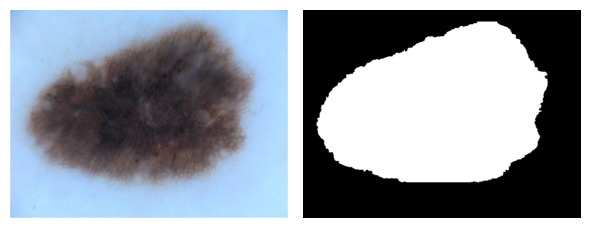

In [10]:
# Visualizing first train image with its label.
img1 = Image.open(train_images_path[0])
img1.thumbnail((512, 512))
img1_label = Image.open(train_labels_path[0])
img1_label.thumbnail((512, 512))
plt.subplots(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img1_label, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
# This function plots 25 random images with segmantation mask.
def plot_segmentation_images(image_path, image_label_path, size=512, Random=True):
    figure = plt.subplots(figsize=(25, 25))
    
    # plotting rows iterating through 
    for i in range(25): 
        random_number = np.random.randint(len(image_path)) if Random else i
        img = Image.open(image_path[random_number])
        img_label = Image.open(image_label_path[random_number])
        img = img.resize((size, size))
        img_label = img_label.resize((size, size))
        img = np.array(img)
        img_label = np.array(img_label)
        mask = np.ma.masked_where(img_label>0, img_label)
        img_label_mask = np.ma.masked_array(img_label, mask)
        img_name = image_label_path[random_number].split('/')[-1]

        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap='gray')
        plt.imshow(img_label_mask, cmap='jet', alpha=0.4)
        plt.xlabel(f'ID: {img_name}', fontsize=15)
    plt.show()

In [12]:
IMG_SIZE = 256
IMG_CHANNELS = 3
batch_size = 8
buffer_size = 1000
steps_per_epoch = len(train_images_path) // batch_size
AUTOTUNE = tf.data.AUTOTUNE

In [13]:
x_train_ds = tf.data.Dataset.list_files(train_images_path, seed=seed)
y_train_ds = tf.data.Dataset.list_files(train_labels_path, seed=seed)
x_val_ds = tf.data.Dataset.list_files(val_images_path, seed=seed)
y_val_ds = tf.data.Dataset.list_files(val_labels_path, seed=seed)

In [14]:
def parse_image(img_path, size=(256,256)):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size)
    return image

def parse_gt(gt_path, size=(256,256)):
    gt = tf.io.read_file(gt_path)
    gt = tf.image.decode_png(gt, channels=1)
    gt = tf.image.resize(gt, size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    gt = tf.where(gt == 0, 0, 1)
    gt = tf.image.convert_image_dtype(gt, tf.int32)
    return gt

In [15]:
x_train_ds = x_train_ds.map(parse_image)
y_train_ds = y_train_ds.map(parse_gt)
x_val_ds = x_val_ds.map(parse_image)
y_val_ds = y_val_ds.map(parse_gt)

In [16]:
print(f'Train x size: {len(x_train_ds)}')
print(f'Validation x size: {len(x_val_ds)}')
print(f'Train y size: {len(y_train_ds)}')
print(f'Validation y size: {len(y_val_ds)}')

Train x size: 2075
Validation x size: 519
Train y size: 2075
Validation y size: 519


In [17]:
train_ds = tf.data.Dataset.zip((x_train_ds, y_train_ds))
val_ds = tf.data.Dataset.zip((x_val_ds, y_val_ds))

In [18]:
def augment(image, mask, size=(256, 256)):
  transforms = A.Compose([
      A.OneOf([
          A.Transpose(),
          A.VerticalFlip(),
          A.HorizontalFlip(),
          A.RandomRotate90(),
          A.NoOp()], p=0.75),

      A.ShiftScaleRotate(p=0.1),
      A.GridDistortion(p=0.1),
      A.ElasticTransform(p=0.1),

      A.OneOf([
          A.RandomBrightnessContrast(),    
          A.RandomGamma()], p=0.2)
      
    ], additional_targets={'mask': 'mask'})

  data = {"image":image, "mask":mask}
  aug_data = transforms(**data)

  aug_img = aug_data["image"]
  aug_img = tf.cast(aug_img, tf.float32)

  aug_mask = aug_data["mask"]
  # Making sure labels are binary (background or label)
  aug_mask = np.where(aug_mask == 0, 0, 1)
  aug_mask = tf.cast(aug_mask, tf.int32)
  return aug_img, aug_mask

# I got "Tensor has no attribute .numpy() method" error. To fix this I used tf.numpy_function()
def process_data(image, mask, h=256, w=256):
  image, mask = tf.numpy_function(func=augment, inp=[image, mask], Tout=(tf.float32, tf.int32))
  # The datasets loses its shape after applying a tf.numpy_function, so this is 
  # necessary for the sequential model and when inheriting from the model class.
  image.set_shape((h, w, 3))
  mask.set_shape((h, w, 1))
  return image, mask

In [19]:
train_ds = (
    train_ds
    .cache()
    .map(partial(process_data))
    .batch(batch_size)
    .repeat()
    .prefetch(buffer_size=AUTOTUNE)
)

# Not appliyingg augmentation on validation data.
val_ds = (
    val_ds
    .cache()
    .batch(batch_size)
    .repeat()
    .prefetch(buffer_size=AUTOTUNE)
)

In [20]:
train_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, 1), dtype=tf.int32, name=None))

(8, 256, 256, 3)
(8, 256, 256, 1)


<ipython-input-21-4066c5f47e81>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(batch_size, 2, i+1)


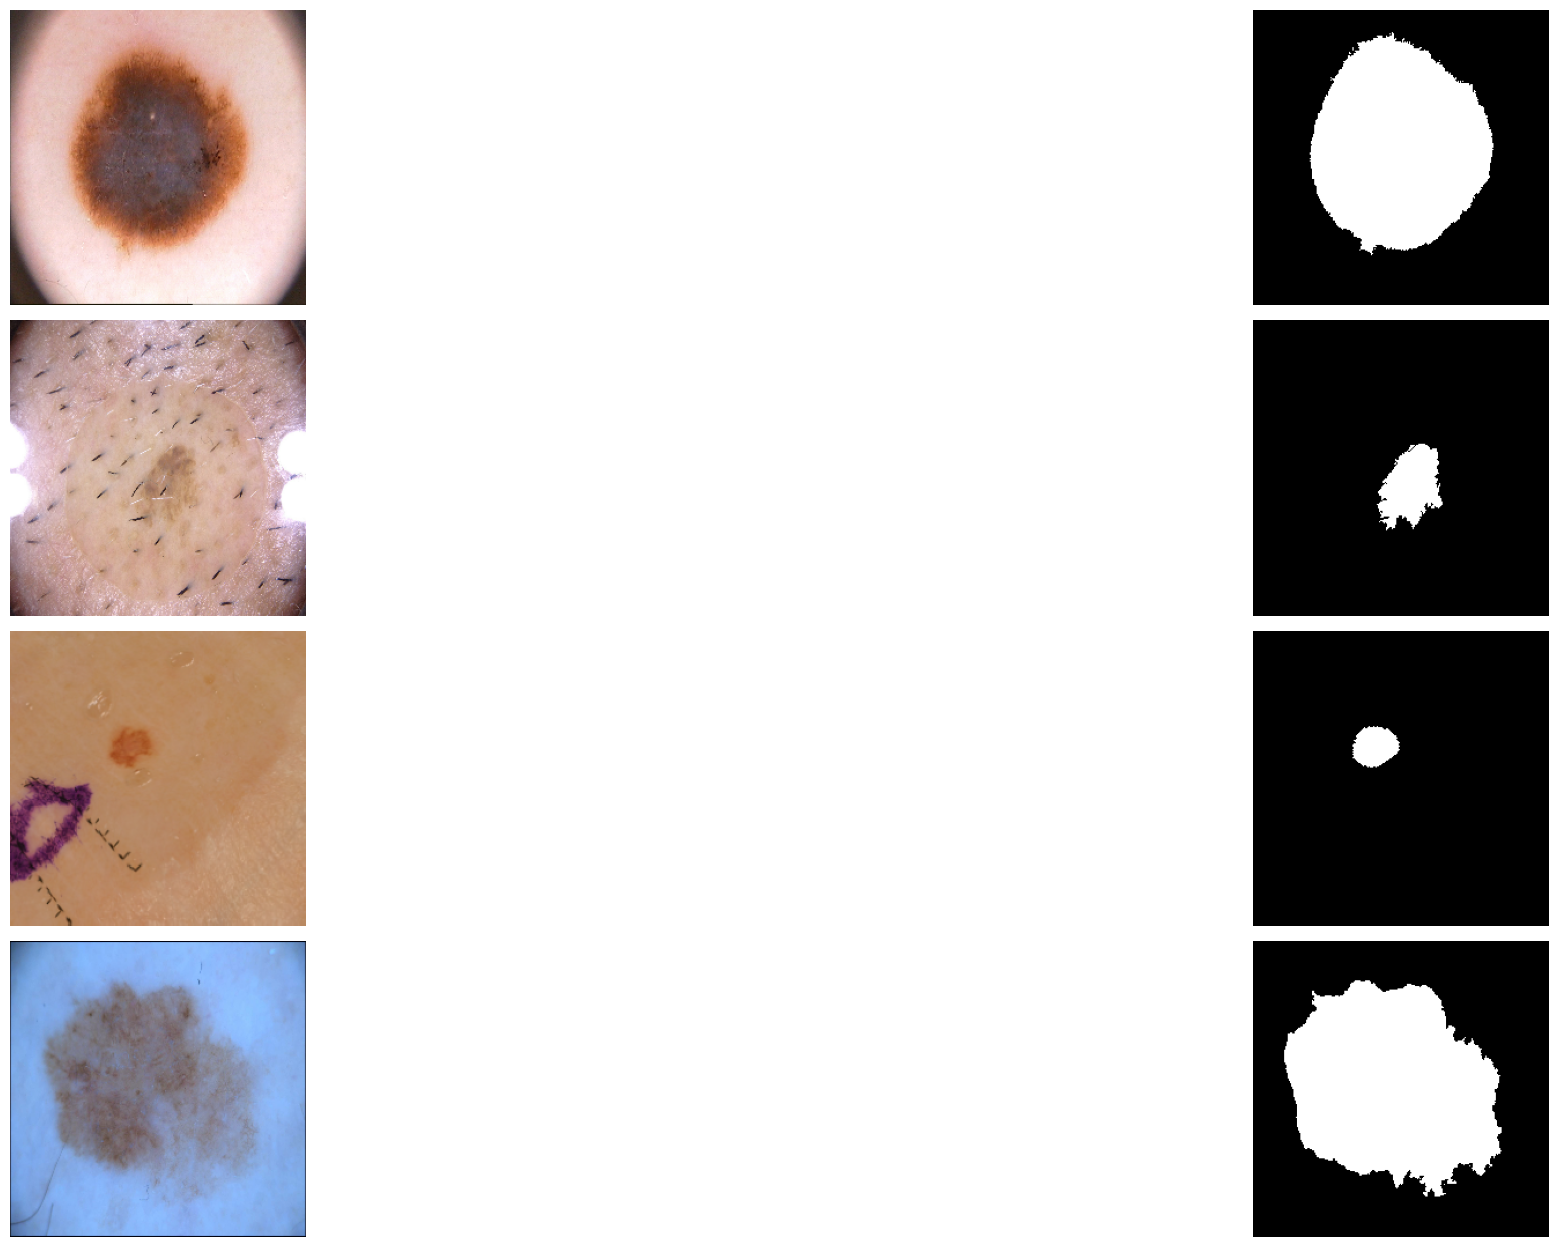

In [21]:
for image, label in train_ds.take(1):
    print(image.shape)
    print(label.shape)
    plt.subplots(figsize=(25, 25))
    for i in range(0, batch_size, 2):
        plt.subplot(batch_size, 2, i+1)
        plt.imshow(image[i])
        plt.axis('off')
        plt.subplot(batch_size, 2, i+2)
        plt.imshow(label[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

In [22]:
test_ds = (
    tf.data.Dataset.list_files(test_images_path)
    .map(parse_image)
    .batch(1))

In [23]:
# Functions to build the encoder path
def conv_block(inp, filters, padding='same', activation='relu'): 
    x = Conv2D(filters, (3, 3), padding=padding, activation=activation)(inp)
    x = Conv2D(filters, (3, 3), padding=padding)(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation)(x)
    return x

def encoder_block(inp, filters, padding='same', pool_stride=2, activation='relu'):
    # Encoder block of a UNet passes the result from the convolution block
    # above to a max pooling layer
    x = conv_block(inp, filters, padding, activation)
    p = MaxPooling2D(pool_size=(2, 2), strides=pool_stride)(x)
    return x, p


# Function to build decoder path
def decoder_block(inp,filters,concat_layer,padding='same'):
    # Upsample the feature maps
    x = Conv2DTranspose(filters, (2,2), strides=(2,2), padding=padding)(inp)
    x = concatenate([x, concat_layer]) # Concatenation/Skip conncetion with conjuagte encoder
    x = conv_block(x, filters) # Passed into the convolution block above
    return x
# Building the first block
def build_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    d1, p1=encoder_block(inputs, 64)
    d2, p2=encoder_block(p1, 128)
    d3, p3=encoder_block(p2, 256)
    d4, p4=encoder_block(p3, 512)
    mid = conv_block(p4, 1024) # Midsection
    e2 = decoder_block(mid, 512, d4) # Conjugate of encoder 4
    e3 = decoder_block(e2, 256, d3) # Conjugate of encoder 3
    e4 = decoder_block(e3, 128, d2) # Conjugate of encoder 2 
    # o1 = Conv2D(1, (1,1), activation=None)(e4) # Output from 2nd last decoder
    e5 = decoder_block(e4, 64, d1) # Conjugate of encoder 1
    outputs = Conv2D(1, (1, 1),activation='sigmoid')(e5) #Final Output
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs], name='Unet')
    return model

In [24]:
#Evaluation Metrics
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    smooth = 1e-7  # Smooth to avoid division by zero
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def iou(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f + y_pred_f - y_true_f * y_pred_f)
    return intersection / union
def precision(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    true_positive = K.sum(y_true_f * y_pred_f)
    false_positive = K.sum((1 - y_true_f) * y_pred_f)
    return true_positive / (true_positive + false_positive + K.epsilon())

def recall(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    true_positive = K.sum(y_true_f * y_pred_f)
    false_negative = K.sum(y_true_f * (1 - y_pred_f))
    return true_positive / (true_positive + false_negative + K.epsilon())
import time

def inference_time(model, data):
    start_time = time.time()
    model.predict(data)  # Make a prediction
    end_time = time.time()
    return end_time - start_time


In [25]:
#Loss
def bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, dtype=y_pred.dtype)
    bce = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
    dice = dice_coef(y_true, y_pred)
    return bce - K.log(dice)
def bce_dice_loss_log(y_true, y_pred):
    y_true = K.cast(y_true, dtype=y_pred.dtype)
    bce = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
    dice = dice_coef(y_true, y_pred)
    return bce + 1 - dice
def iou_loss(y_true, y_pred):
    return 1 - iou(y_true, y_pred)
def precision_recall_loss(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 1 - (2 * p * r) / (p + r + K.epsilon())  # This is the F1 score
def bce_precision_recall_loss(y_true, y_pred):
    bce = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1 = (2 * p * r) / (p + r + K.epsilon())
    return bce - f1


In [26]:
model = build_model(IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=bce_dice_loss_log, 
              metrics=[dice_coef, iou, precision, recall, 'accuracy'])

In [27]:
steps_per_epoch = int(len(train_images_path)*0.8 // batch_size)
val_steps = int(len(train_images_path)*0.2 // batch_size)
print(f"Batch Size: {batch_size}\nSteps_per_epoch: {steps_per_epoch}\nValidation_steps: {val_steps}")

Batch Size: 8
Steps_per_epoch: 207
Validation_steps: 51


In [28]:
callbacks = [
    EarlyStopping(monitor='val_dice_coef', patience=10, mode='max'),
    ModelCheckpoint(filepath='saved_model.keras', monitor='val_dice_coef', save_best_only=True),
    ReduceLROnPlateau(monitor='val_dice_coef', factor=0.2, patience=5, verbose=1, min_lr=5e-7)
]

In [29]:
history = model.fit(train_ds, epochs=10, verbose=2,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=val_steps,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/10
207/207 - 262s - 1s/step - accuracy: 0.8451 - dice_coef: 0.5202 - iou: 0.3597 - loss: 0.8781 - precision: 0.5009 - recall: 0.5910 - val_accuracy: 0.4501 - val_dice_coef: 0.4921 - val_iou: 0.3330 - val_loss: 3.7200 - val_precision: 0.3345 - val_recall: 0.9880 - learning_rate: 0.0010
Epoch 2/10
207/207 - 111s - 535ms/step - accuracy: 0.8901 - dice_coef: 0.6360 - iou: 0.4737 - loss: 0.6774 - precision: 0.6467 - recall: 0.6653 - val_accuracy: 0.8396 - val_dice_coef: 0.7277 - val_iou: 0.5794 - val_loss: 0.9970 - val_precision: 0.6354 - val_recall: 0.8819 - learning_rate: 0.0010
Epoch 3/10
207/207 - 51s - 246ms/step - accuracy: 0.9052 - dice_coef: 0.6911 - iou: 0.5339 - loss: 0.5785 - precision: 0.7030 - recall: 0.7151 - val_accuracy: 0.8995 - val_dice_coef: 0.7600 - val_iou: 0.6163 - val_loss: 0.5082 - val_precision: 0.7980 - val_recall: 0.7372 - learning_rate: 0.0010
Epoch 4/10
207/207 - 51s - 248ms/step - accuracy: 0.9081 - dice_coef: 0.7061 - iou: 0.5519 - loss: 0.5542 - preci

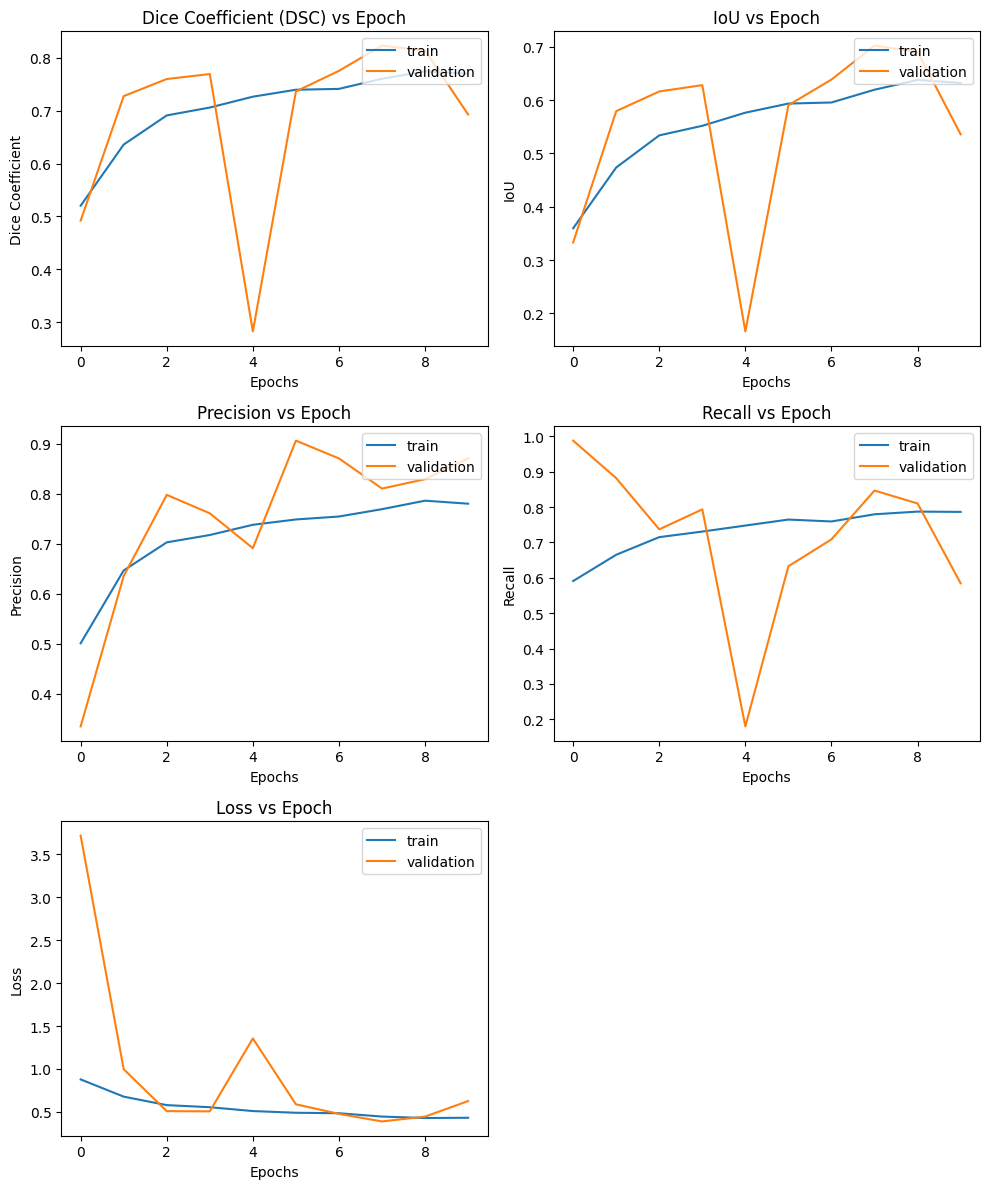

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))

# Dice coefficient plot
plt.subplot(3,2,1)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Dice Coefficient (DSC) vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend(['train', 'validation'], loc='upper right')
plt.tight_layout()

# IoU plot
plt.subplot(3,2,2)
plt.plot(history.history['iou'])
plt.plot(history.history['val_iou'])
plt.title('IoU vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend(['train', 'validation'], loc='upper right')
plt.tight_layout()

# Precision plot
plt.subplot(3,2,3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Precision vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(['train', 'validation'], loc='upper right')
plt.tight_layout()

# Recall plot
plt.subplot(3,2,4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(['train', 'validation'], loc='upper right')
plt.tight_layout()

# Loss plot
plt.subplot(3,2,5)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.tight_layout()

# Inference time plot (if you tracked this metric separately)
# For simplicity, assuming `inference_time` is in history.history
if 'inference_time' in history.history:
    plt.subplot(3,2,6)
    plt.plot(history.history['inference_time'])
    plt.title('Inference Time vs Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Inference Time (s)')
    plt.tight_layout()

plt.show()


In [31]:
K.clear_session()
raw_predictions = model.predict(test_ds)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 60s 58ms/step


In [32]:
predictions = np.where(raw_predictions < 0.5, 0, 1)

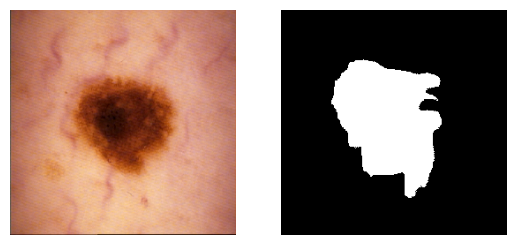

In [33]:
image = [images[0].numpy() for images in test_ds.take(1)]
# Looking at an example before creating saving outputs as image.
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(image[0]) # Using index 0 because it is in shape of (1, 256, 256, 1)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(predictions[0], cmap='gray')
plt.show()

In [34]:
if not os.path.exists('predictions'):
    os.makedirs('predictions')

# loop through the predictions and save each one as an image
for i, pred in tqdm(enumerate(predictions)):
    pred = (pred * 255).astype(np.uint8)
    image = Image.fromarray(pred.squeeze())
    filename = f"prediction_{i}.png"
    image.save(os.path.join('predictions', filename))

1000it [00:01, 987.30it/s]


<ipython-input-11-834e2f38d505>:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, i+1)


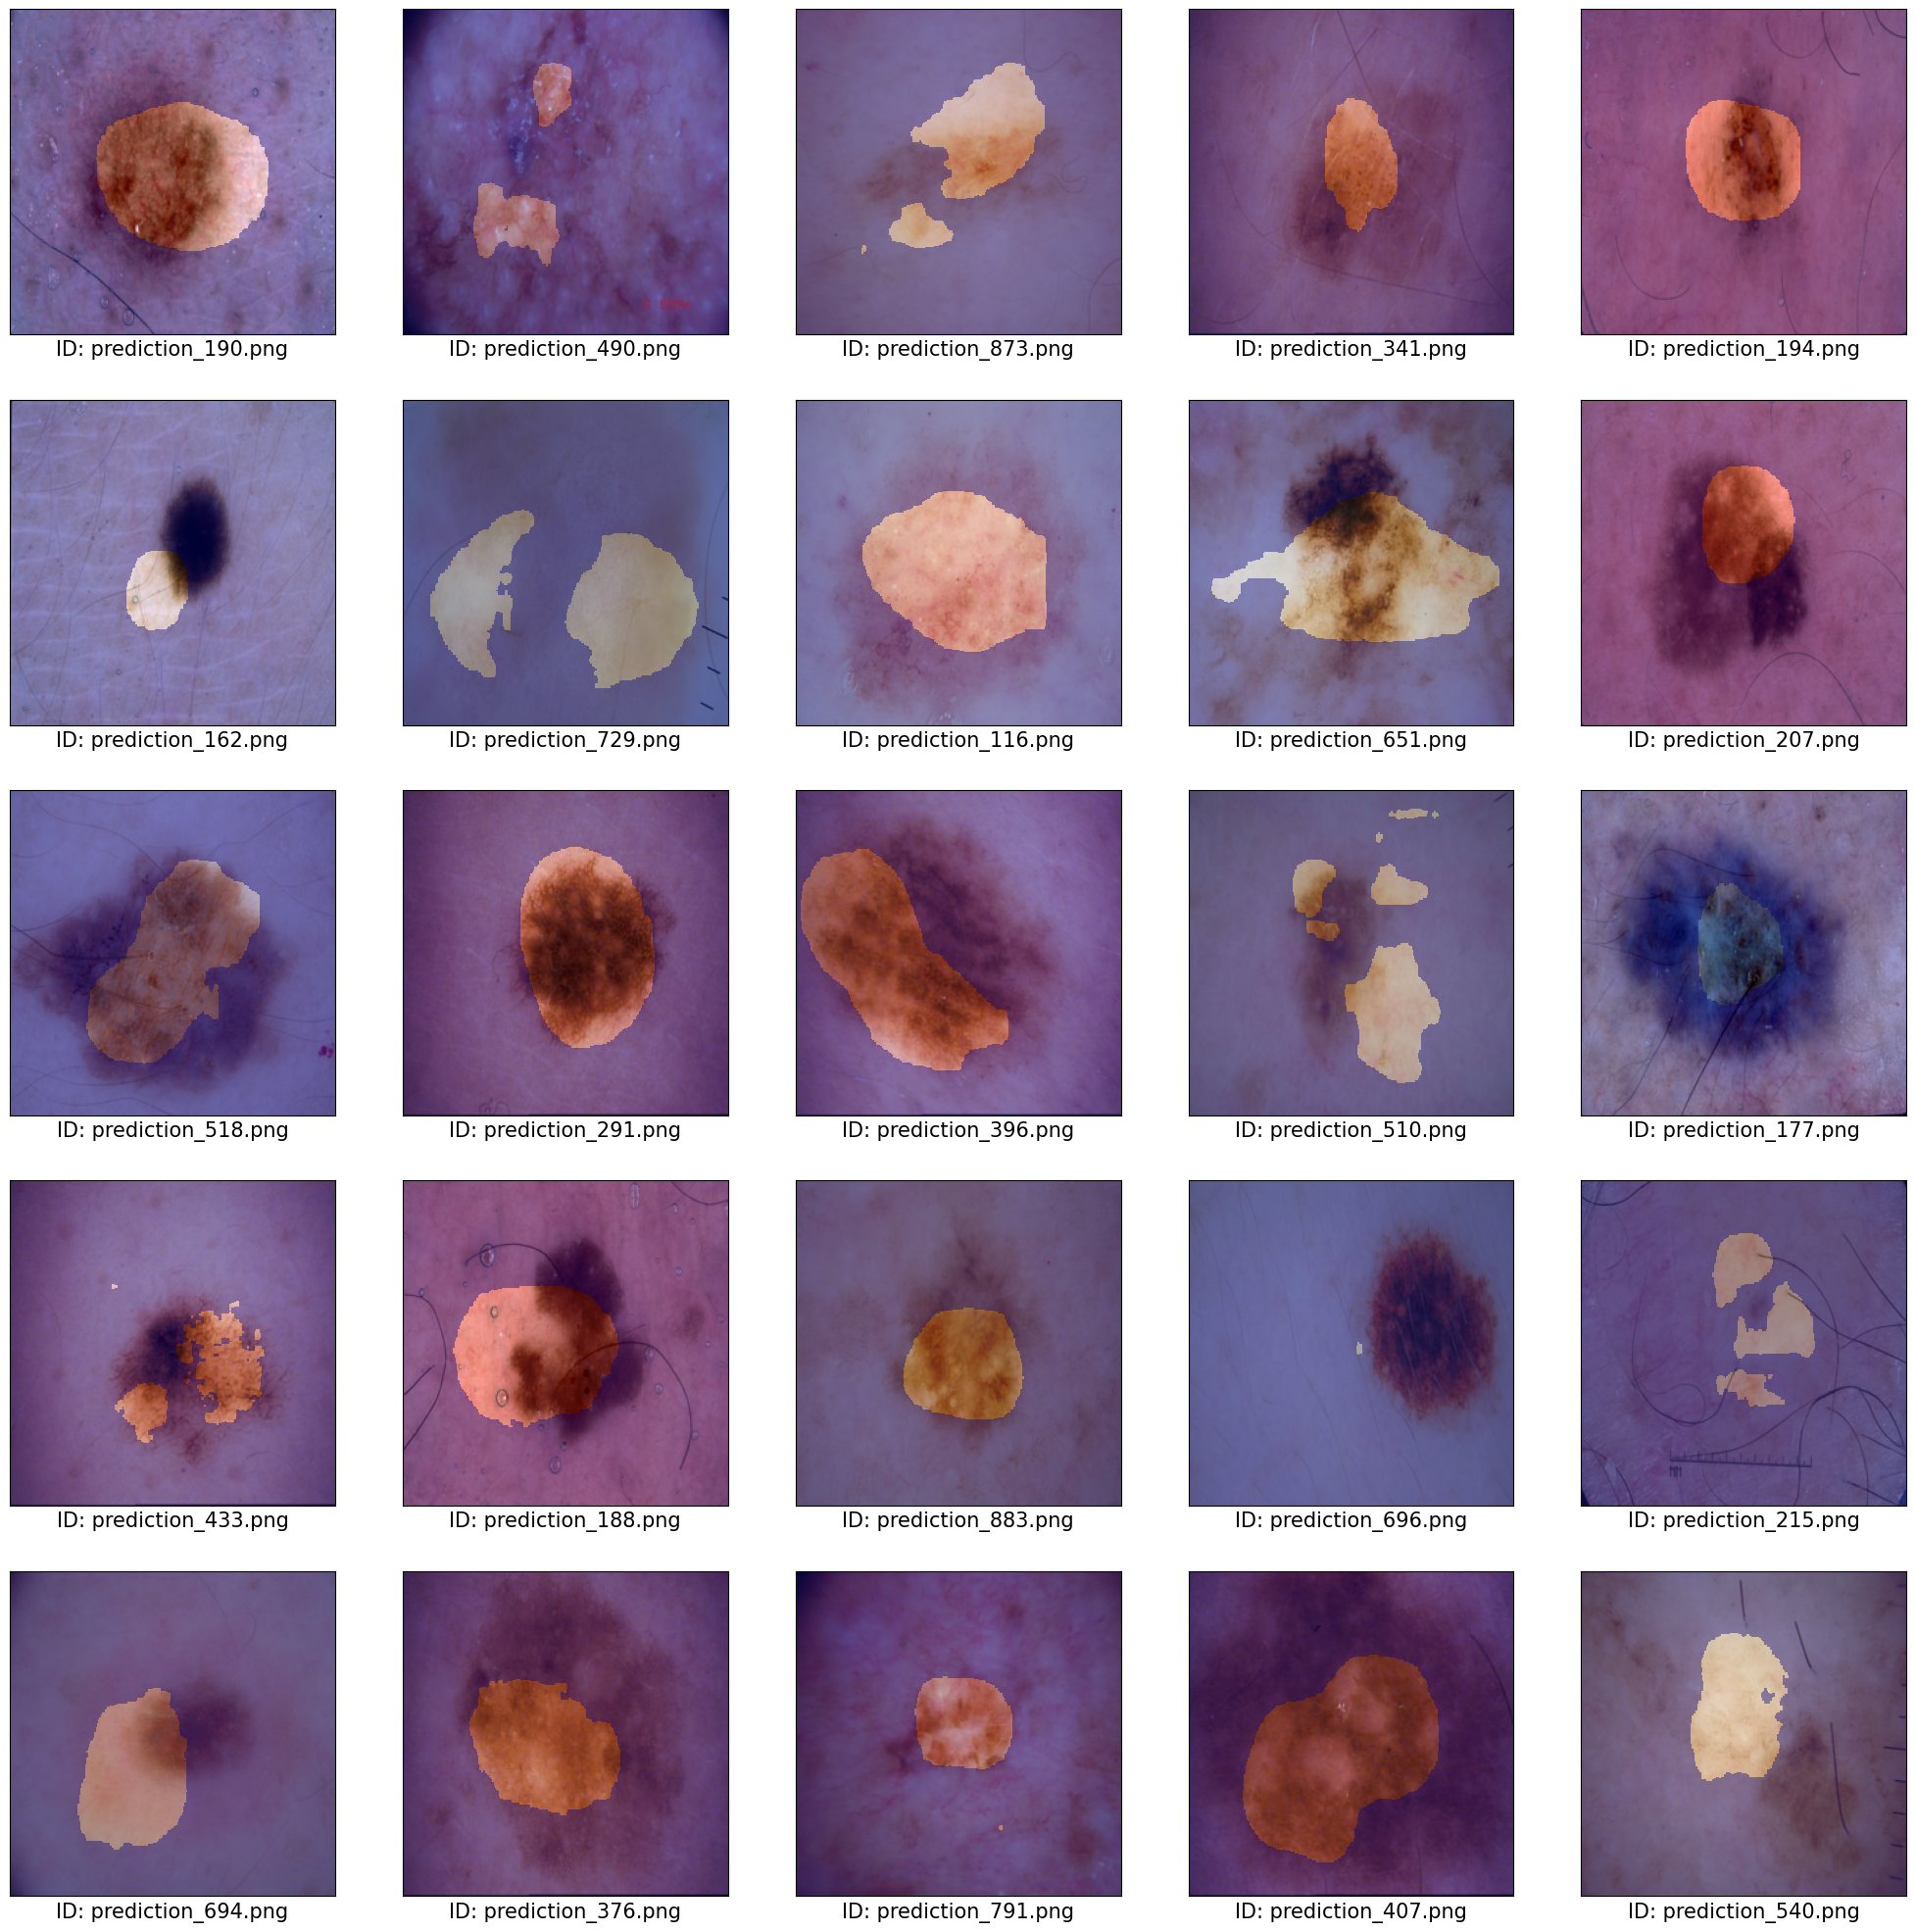

In [35]:
pred_folder_path = os.path.join(os.getcwd(), 'predictions')
pred_images_path = np.sort([os.path.join(pred_folder_path, i) for i in os.listdir(pred_folder_path) if i.endswith('.png')])
plot_segmentation_images(test_images_path, pred_images_path, size=256, Random=True)